In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# TODO: Translate this notebook to unittests

Defining a testing signal, for this I take a sinoid with a small Gaussian pulse on it (only positive)

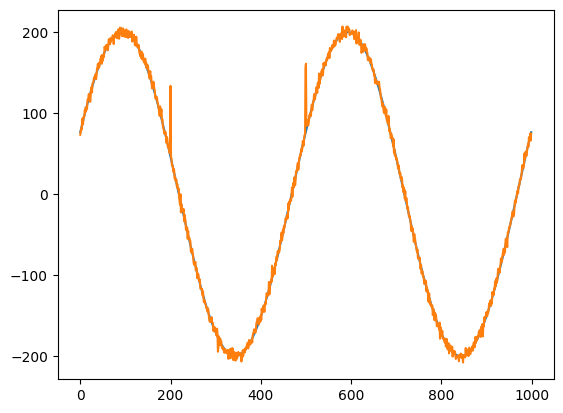

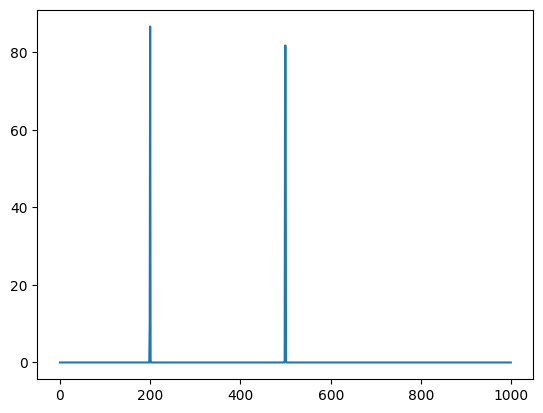

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import gausspulse


lf_amplitude=200
hf_amplitude=100
no_samples=1000
lf_frequency=2
hf_duration=10
hf_occurence=24
noise_amplitude = 4

t = np.linspace(0, 1, no_samples)   # Timevector

y_lf = lf_amplitude*np.sin(
    2*np.pi*t*lf_frequency + np.pi/8
)

_ , y_hf = gausspulse(t - 0.2, fc=2000, retenv=True)
y_hf = y_hf * hf_amplitude

_ , y_hf2 = gausspulse(t - 0.5, fc=2000, retenv=True)
y_hf2 = y_hf2 * hf_amplitude*2

_ , y_hf3 = gausspulse(t - 0.4, fc=2000, retenv=True)
y_hf3 = y_hf3 * (-hf_amplitude)

y_hf = y_hf + y_hf2 #+ y_hf3

# Add noise to y_lf data
y_noise = np.random.normal(0, noise_amplitude, no_samples)

plt.plot(y_lf)
plt.plot(y_hf+y_lf+y_noise)
plt.show()
plt.plot(y_hf)
plt.show()

# plt.xlim([400,600])

In [4]:
from filter_tc.timeseries import temp_comp_pf
from sklearn.linear_model import LinearRegression
def learn_alpha(strain, temperature):
    linregr = LinearRegression()
    linregr.fit(strain, temperature)
    alpha = linregr.coef_[0]
    return alpha

In [6]:
input = {
    'data': y_lf,
    'name': 'test_lf',
    'unit_str': '°C',
    'fs':1
}

measurements = {
    'data': y_lf+y_hf+y_noise,
    'name': 'test_measurement',
    'unit_str' : 'microstrain',
    'fs':1
}

filtered = temp_comp_pf(
    measurements,
    input,
    num_particles=100,
    r_measurement_noise=0.01,
    q_process_noise=np.array([1e-4, 5e-1]),
    scale=1,
    loading='tension'
)

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

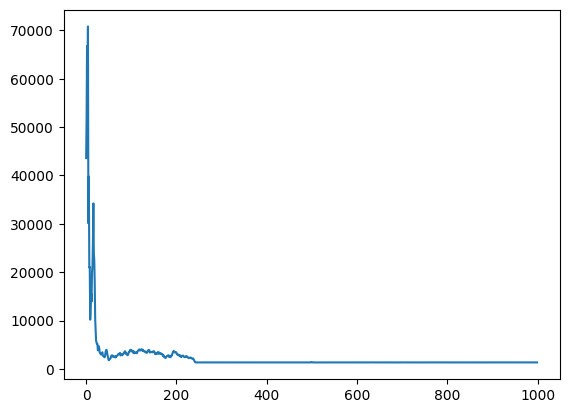

In [ ]:
plt.plot(filtered['data'].flatten())

# Trying to better understand the functionality

Introducing just the ParticleFilter element. To understand how it works.

1.0016193408313137


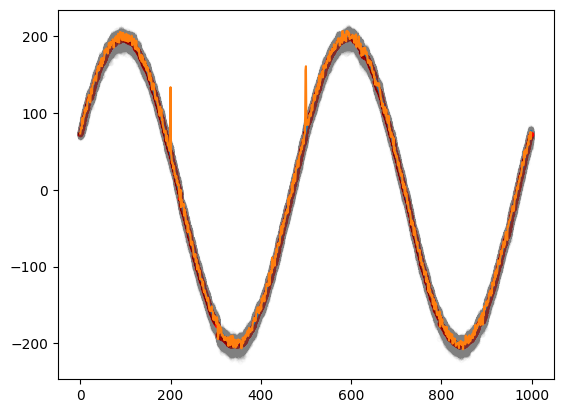

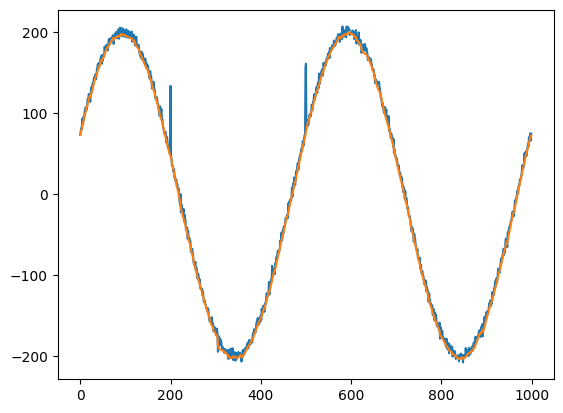

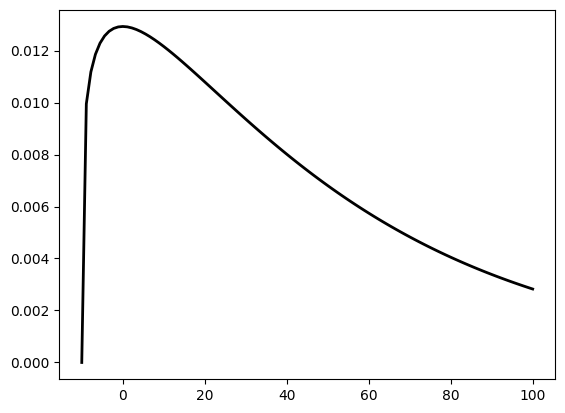

In [11]:
from filter_tc.particle_filter import ParticleFilter

measurements = y_lf+y_noise+y_hf
input= np.vstack([y_lf, np.insert(np.diff(y_lf),0,0)])

num_particles=1000


pf_alpha = learn_alpha(input[0].reshape(-1, 1),measurements)
print(pf_alpha)
pf = ParticleFilter(
    num_particles=num_particles,
    r_measurement_noise=5e1,
    q_process_noise=np.array([2, 1]),
    scale=5e-3,
    loc=-10,
    alpha = pf_alpha)

loading = 'tension'
mean = np.array([measurements[0], 0]) # Start with the starting variable
std = np.array([0.1, 0.1]) # TODO: @MaxWeil where does this come from, is it a setting?
# NOTE: @WoutWeijtjens this is indeed a setting to generate random particles around the mean (gaussian particles)
pf.create_gaussian_particles(mean, std)
pf.predictions = np.zeros(len(measurements))
for i, measurement in enumerate(measurements):
    pf.predict(input[:,i])
    #print(self.particles, self.weights)
    pf.update(measurement, loading=loading)
    #print(self.particles, self.weights)
    pf.simple_resample(loading=loading)
    #print(self.particles, self.weights)
    prediction, var = pf.estimate()
    #print(self.particles, self.weights)
    pf.predictions[i] = prediction

    plt.plot(np.ones(num_particles)*i,pf.particles[:,0], marker='.', color='gray', alpha=0.01, linestyle='')
    plt.plot(i, prediction, marker='.', color='r')

plt.plot(y_lf)
plt.plot(measurements)

# plt.ylim([-10,10])
plt.show()
plt.plot(measurements)
plt.plot(pf.predictions)

plt.show()

# plot noise ditribution
x = np.linspace(-10, 100, 100)
plt.plot(x, pf.event_distribution.pdf(x), 'k-', lw=2, label='frozen pdf')

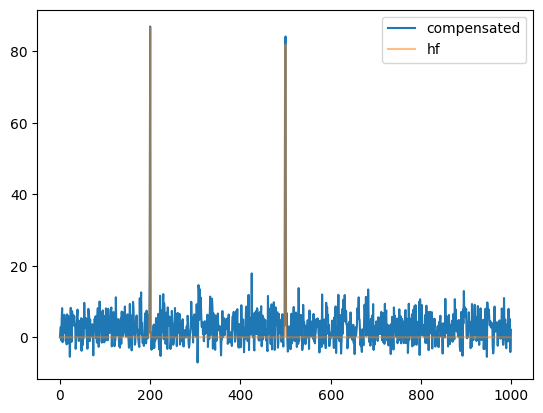

In [12]:
plt.plot(measurements-pf.predictions, label='compensated')
plt.plot(y_hf, label='hf', alpha=0.5)
plt.legend()

## Testing on a different scale influence between input and measurements

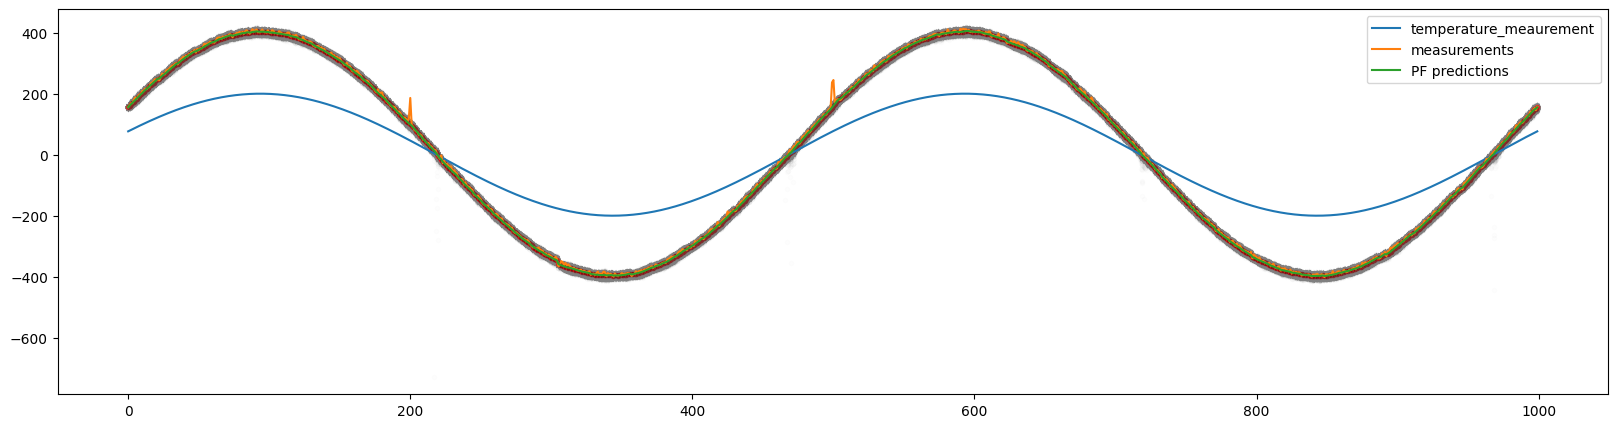

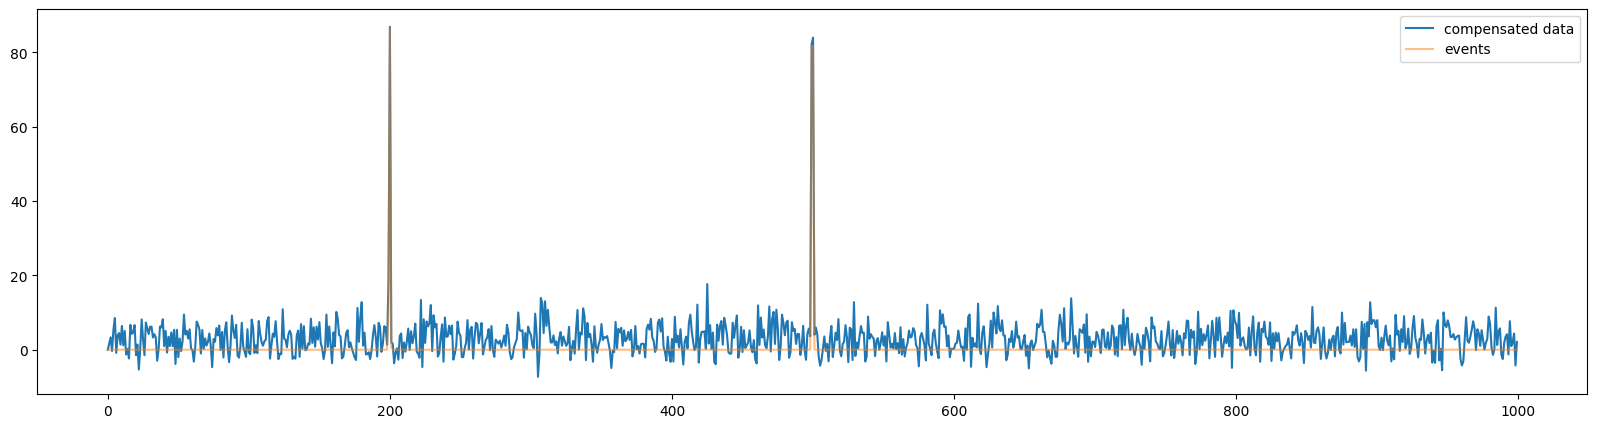

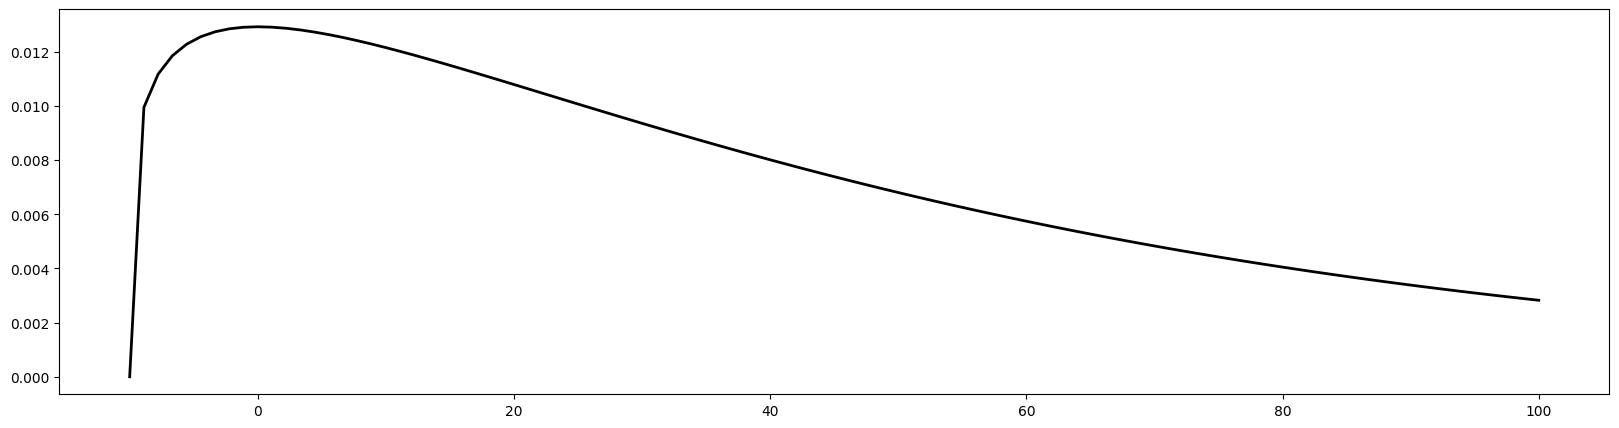

In [13]:
measurements = y_lf*2 + 6 + y_noise + y_hf
input= np.vstack([y_lf, np.insert(np.diff(y_lf),0,0)])
#learn the temperature coefficient
pf_alpha = learn_alpha(input[0].reshape(-1, 1),measurements)

num_particles=1000
pf = ParticleFilter(
    num_particles=num_particles,
    r_measurement_noise=5e1,
    q_process_noise=np.array([2, 1]),
    scale=1,
    loc=-10,
    alpha = pf_alpha)

#pf.alpha = 0.4

loading = 'tension'
mean = np.array([measurements[0], 0]) # Start with the starting variable
std = np.array([1.0, 1.0]) # TODO: @MaxWeil where does this come from, is it a setting?
# NOTE: @WoutWeijtjens this is indeed a setting to generate random particles around the mean (gaussian particles)
pf.create_gaussian_particles(mean, std)
pf.predictions = np.zeros(len(measurements))
plt.figure(figsize=(20,5))
for i, measurement in enumerate(measurements):
    pf.predict(input[:,i])
    #print(self.particles, self.weights)
    pf.update(measurement, loading=loading)
    #print(self.particles, self.weights)
    pf.simple_resample(loading=loading)
    #print(self.particles, self.weights)
    prediction, var = pf.estimate()
    #print(self.particles, self.weights)
    pf.predictions[i] = prediction

    plt.plot(np.ones(num_particles)*i,pf.particles[:,0], marker='.', color='gray', alpha=0.01, linestyle='')
    plt.plot(i, prediction, marker='.', color='r',alpha=0.5)

plt.plot(y_lf, label='temperature_meaurement')
plt.plot(measurements, label='measurements')
plt.plot(pf.predictions, label='PF predictions')
plt.legend()
plt.show()
plt.figure(figsize=(20,5))
plt.plot(measurements - pf.predictions, label='compensated data')
plt.plot(y_hf, alpha=0.5, label='events')
plt.legend()
plt.show()
# plot noise ditribution
plt.figure(figsize=(20,5))
x = np.linspace(-10, 100, 100)
plt.plot(x, pf.event_distribution.pdf(x), 'k-', lw=2, label='frozen pdf')

In [10]:
measurements = y_lf/5 + 6 + y_noise + y_hf
input= np.vstack([y_lf, np.insert(np.diff(y_lf),0,0)])
#learn the temperature coefficient
pf_alpha = learn_alpha(input[0].reshape(-1, 1),measurements)

num_particles=1000
pf = ParticleFilter(
    num_particles=num_particles,
    r_measurement_noise=5e1,
    q_process_noise=np.array([2, 1]),
    scale=5e-3,
    loc=-10,
    alpha = pf_alpha)

#pf.alpha = 0.4

loading = 'tension'
mean = np.array([measurements[0], 0]) # Start with the starting variable
std = np.array([1.0, 1.0]) # TODO: @MaxWeil where does this come from, is it a setting?
# NOTE: @WoutWeijtjens this is indeed a setting to generate random particles around the mean (gaussian particles)
pf.create_gaussian_particles(mean, std)
pf.predictions = np.zeros(len(measurements))
plt.figure(figsize=(20,5))
for i, measurement in enumerate(measurements):
    pf.predict(input[:,i])
    #print(self.particles, self.weights)
    pf.update(measurement, loading=loading)
    #print(self.particles, self.weights)
    pf.simple_resample(loading=loading)
    #print(self.particles, self.weights)
    prediction, var = pf.estimate()
    #print(self.particles, self.weights)
    pf.predictions[i] = prediction

    plt.plot(np.ones(num_particles)*i,pf.particles[:,0], marker='.', color='gray', alpha=0.1, linestyle='')
    plt.plot(i, prediction, marker='.', color='r',alpha=0.5)

plt.plot(y_lf, label='temperature_meaurement')
plt.plot(measurements, label='measurements')
plt.plot(pf.predictions, label='PF predictions')
plt.legend()
plt.show()
plt.figure(figsize=(20,5))
plt.plot(measurements - pf.predictions, label='compensated data')
plt.plot(y_hf, alpha=0.5, label='events')
plt.legend()
plt.show()
# plot noise ditribution
plt.figure(figsize=(20,5))
x = np.linspace(-10, 100, 100)
plt.plot(x, pf.event_distribution.pdf(x), 'k-', lw=2, label='frozen pdf')

KeyboardInterrupt: 

### Wrong temperature coefficient

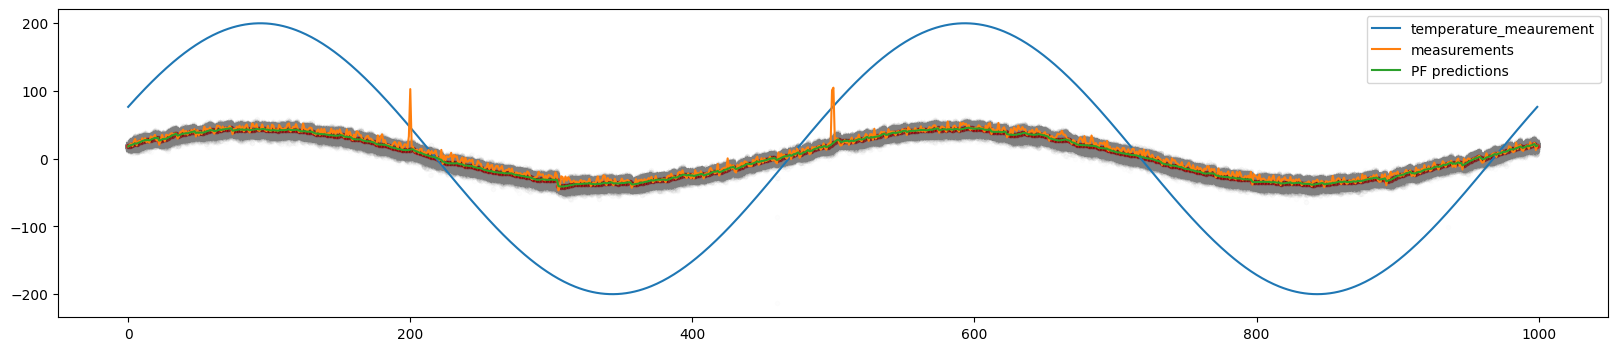

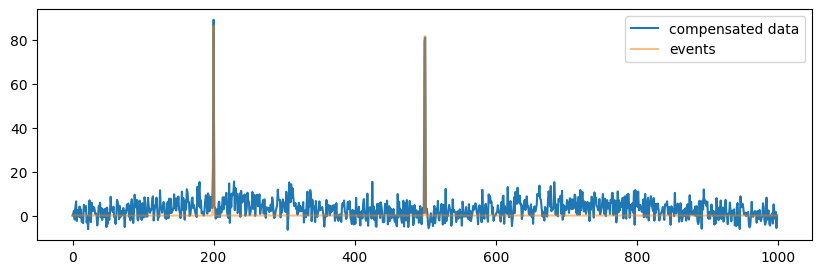

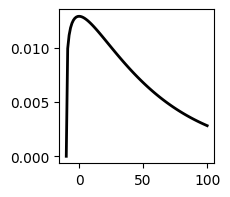

In [14]:
measurements = y_lf/5 + 6 + y_noise + y_hf
input= np.vstack([y_lf, np.insert(np.diff(y_lf),0,0)])
#learn the temperature coefficient
pf_alpha = 2 * learn_alpha(input[0].reshape(-1, 1),measurements)

num_particles=1000
pf = ParticleFilter(
    num_particles=num_particles,
    r_measurement_noise=5e1,
    q_process_noise=np.array([2, 1]),
    scale=5e-3,
    loc=-10,
    alpha = pf_alpha)

loading = 'tension'
mean = np.array([measurements[0], 0]) # Start with the starting variable
std = np.array([1.0, 1.0]) # TODO: @MaxWeil where does this come from, is it a setting?
# NOTE: @WoutWeijtjens this is indeed a setting to generate random particles around the mean (gaussian particles)
pf.create_gaussian_particles(mean, std)
pf.predictions = np.zeros(len(measurements))
plt.figure(figsize=(20,4))
for i, measurement in enumerate(measurements):
    pf.predict(input[:,i])
    #print(self.particles, self.weights)
    pf.update(measurement, loading=loading)
    #print(self.particles, self.weights)
    pf.simple_resample(loading=loading)
    #print(self.particles, self.weights)
    prediction, var = pf.estimate()
    #print(self.particles, self.weights)
    pf.predictions[i] = prediction

    plt.plot(np.ones(num_particles)*i,pf.particles[:,0], marker='.', color='gray', alpha=0.01, linestyle='')
    plt.plot(i, prediction, marker='.', color='r',alpha=0.5)

plt.plot(y_lf, label='temperature_meaurement')
plt.plot(measurements, label='measurements')
plt.plot(pf.predictions, label='PF predictions')
plt.legend()
plt.show()
plt.figure(figsize=(10,3))
plt.plot(measurements - pf.predictions, label='compensated data')
plt.plot(y_hf, alpha=0.5, label='events')
plt.legend()
plt.show()
# plot noise ditribution
plt.figure(figsize=(2,2))
x = np.linspace(-10, 100, 100)
plt.plot(x, pf.event_distribution.pdf(x), 'k-', lw=2, label='frozen pdf')

### Time delay between temperature and measurement

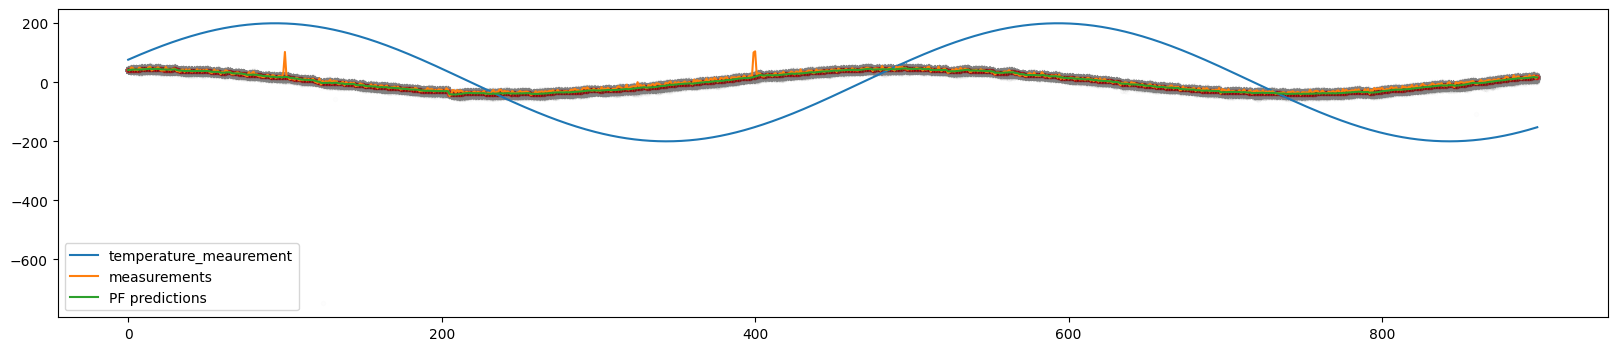

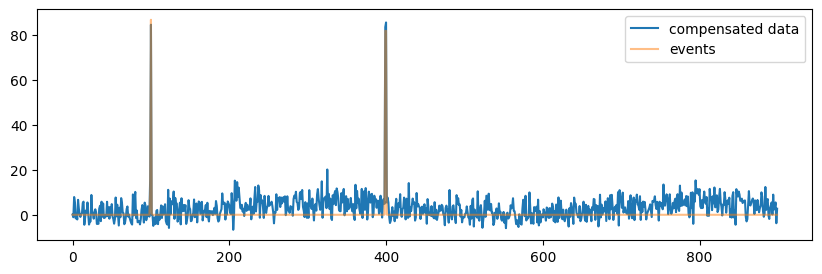

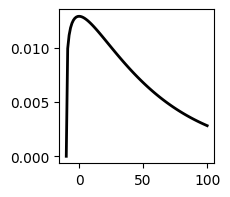

In [15]:
delay = 100
measurements = y_lf/5 + 6 + y_noise + y_hf
measurements = measurements[delay:]
input= np.vstack([y_lf, np.insert(np.diff(y_lf),0,0)])
input = input[:,:-delay]
#learn the temperature coefficient
pf_alpha = 2 * learn_alpha(input[0].reshape(-1, 1),measurements)

num_particles=1000
pf = ParticleFilter(
    num_particles=num_particles,
    r_measurement_noise=5e1,
    q_process_noise=np.array([2, 1]),
    scale=5e-3,
    loc=-10,
    alpha = pf_alpha)

loading = 'tension'
mean = np.array([measurements[0], 0]) # Start with the starting variable
std = np.array([1.0, 1.0]) # TODO: @MaxWeil where does this come from, is it a setting?
# NOTE: @WoutWeijtjens this is indeed a setting to generate random particles around the mean (gaussian particles)
pf.create_gaussian_particles(mean, std)
pf.predictions = np.zeros(len(measurements))
plt.figure(figsize=(20,4))
for i, measurement in enumerate(measurements):
    pf.predict(input[:,i])
    #print(self.particles, self.weights)
    pf.update(measurement, loading=loading)
    #print(self.particles, self.weights)
    pf.simple_resample(loading=loading)
    #print(self.particles, self.weights)
    prediction, var = pf.estimate()
    #print(self.particles, self.weights)
    pf.predictions[i] = prediction

    plt.plot(np.ones(num_particles)*i,pf.particles[:,0], marker='.', color='gray', alpha=0.01, linestyle='')
    plt.plot(i, prediction, marker='.', color='r',alpha=0.5)

plt.plot(input[0], label='temperature_meaurement')
plt.plot(measurements, label='measurements')
plt.plot(pf.predictions, label='PF predictions')
plt.legend()
plt.show()
plt.figure(figsize=(10,3))
plt.plot(measurements - pf.predictions, label='compensated data')
plt.plot(y_hf[delay:], alpha=0.5, label='events')
plt.legend()
plt.show()
# plot noise ditribution
plt.figure(figsize=(2,2))
x = np.linspace(-10, 100, 100)
plt.plot(x, pf.event_distribution.pdf(x), 'k-', lw=2, label='frozen pdf')

##### Filter that overly follows the measurements (no detection of event)

In [16]:
measurements = y_lf/5 + 6 + y_noise + y_hf


input= np.vstack([y_lf, np.insert(np.diff(y_lf),0,0)])

num_particles=1000

pf = ParticleFilter(
    num_particles=num_particles,
    r_measurement_noise=5e-1,
    q_process_noise=np.array([1e2, 1e10]),
    scale=1e-3,
    loc = -0.5
)

loading = 'tension'
mean = np.array([measurements[0], 0]) # Start with the starting variable
std = np.array([1.0, 1.0]) # TODO: @MaxWeil where does this come from, is it a setting?
# NOTE: @WoutWeijtjens this is indeed a setting to generate random particles around the mean (gaussian particles)
pf.create_gaussian_particles(mean, std)
pf.predictions = np.zeros(len(measurements))
for i, measurement in enumerate(measurements):
    pf.predict(input[:,i])
    #print(self.particles, self.weights)
    pf.update(measurement, loading=loading)
    #print(self.particles, self.weights)
    pf.simple_resample(loading=loading)
    #print(self.particles, self.weights)
    prediction, var = pf.estimate()
    #print(self.particles, self.weights)
    pf.predictions[i] = prediction

    plt.plot(np.ones(num_particles)*i,pf.particles[:,0], marker='.', color='gray', alpha=0.01, linestyle='')
    plt.plot(i, prediction, marker='.', color='r')

plt.plot(y_lf)
plt.plot(measurements)
plt.plot(pf.predictions)
plt.show()
plt.plot(measurements - pf.predictions)
plt.plot(y_hf, alpha=0.5)
plt.show()
# plot noise ditribution
x = np.linspace(-5, 10, 100)
plt.plot(x, pf.event_distribution.pdf(x), 'k-', lw=2, label='frozen pdf')

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

##### Filter that overly follows the inputs (no good smoothing of the actual measurements)

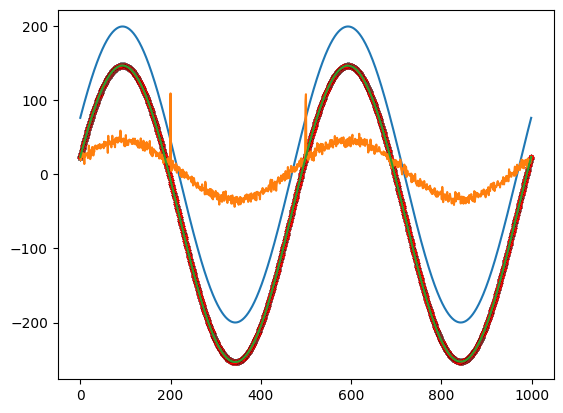

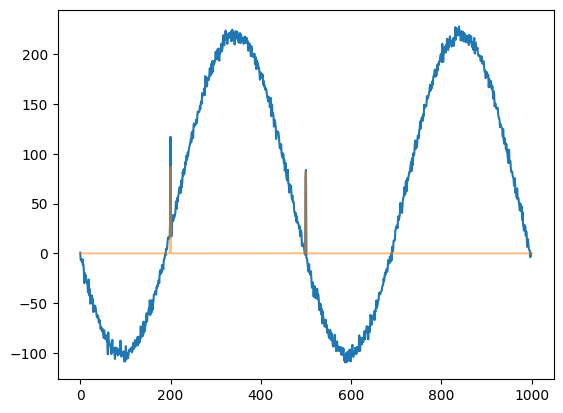

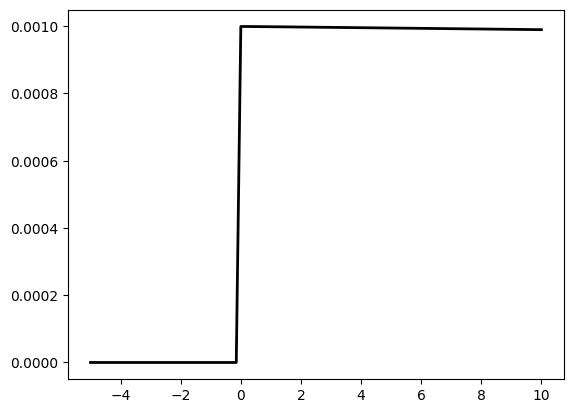

In [ ]:
measurements = y_lf/5 + 6 + y_noise + y_hf

input= np.vstack([y_lf, np.insert(np.diff(y_lf),0,0)])

num_particles=1000

pf = ParticleFilter(
    num_particles=num_particles,
    r_measurement_noise=1e3,
    q_process_noise=np.array([2e-2, 1e-1]),
    scale=1e-3
)

loading = 'tension'
mean = np.array([measurements[0], 0]) # Start with the starting variable
std = np.array([1.0, 1.0]) # TODO: @MaxWeil where does this come from, is it a setting?
# NOTE: @WoutWeijtjens this is indeed a setting to generate random particles around the mean (gaussian particles)
pf.create_gaussian_particles(mean, std)
pf.predictions = np.zeros(len(measurements))
for i, measurement in enumerate(measurements):
    pf.predict(input[:,i])
    #print(self.particles, self.weights)
    pf.update(measurement, loading=loading)
    #print(self.particles, self.weights)
    pf.simple_resample(loading=loading)
    #print(self.particles, self.weights)
    prediction, var = pf.estimate()
    #print(self.particles, self.weights)
    pf.predictions[i] = prediction

    plt.plot(np.ones(num_particles)*i,pf.particles[:,0], marker='.', color='gray', alpha=0.01, linestyle='')
    plt.plot(i, prediction, marker='.', color='r')

plt.plot(y_lf)
plt.plot(measurements)
plt.plot(pf.predictions)
plt.show()
plt.plot(measurements - pf.predictions)
plt.plot(y_hf, alpha=0.5)
plt.show()
# plot noise ditribution
x = np.linspace(-5, 10, 100)
plt.plot(x, pf.event_distribution.pdf(x), 'k-', lw=2, label='frozen pdf')
# plt.ylim([-10,10])


# ParticleFilterBank

In [ ]:
y_lf[:100]

array([ 76.53668647,  78.85485687,  81.16055023,  83.45340172,
        85.73304856,  87.99913004,  90.25128761,  92.4891649 ,
        94.71240783,  96.92066461,  99.11358585, 101.29082455,
       103.45203621, 105.59687888, 107.72501318, 109.83610238,
       111.92981244, 114.00581209, 116.06377284, 118.10336906,
       120.12427804, 122.12618   , 124.1087582 , 126.07169893,
       128.0146916 , 129.93742878, 131.83960624, 133.72092299,
       135.58108136, 137.41978703, 139.23674905, 141.03167994,
       142.80429568, 144.5543158 , 146.2814634 , 147.98546519,
       149.66605155, 151.32295657, 152.95591808, 154.5646777 ,
       156.14898087, 157.70857693, 159.24321908, 160.75266452,
       162.23667441, 163.69501393, 165.12745233, 166.53376296,
       167.91372331, 169.26711503, 170.59372397, 171.89334022,
       173.16575816, 174.41077644, 175.62819808, 176.81783043,
       177.97948528, 179.1129788 , 180.21813166, 181.29476899,
       182.34272043, 183.36182016, 184.35190694, 185.31

In [ ]:

np.append(y_lf[100:],y_lf[:100])

array([ 1.99363570e+02,  1.99147262e+02,  1.98899443e+02,  1.98620152e+02,
        1.98309435e+02,  1.97967339e+02,  1.97593919e+02,  1.97189234e+02,
        1.96753349e+02,  1.96286331e+02,  1.95788256e+02,  1.95259201e+02,
        1.94699251e+02,  1.94108495e+02,  1.93487024e+02,  1.92834939e+02,
        1.92152342e+02,  1.91439341e+02,  1.90696049e+02,  1.89922584e+02,
        1.89119067e+02,  1.88285627e+02,  1.87422394e+02,  1.86529507e+02,
        1.85607105e+02,  1.84655334e+02,  1.83674346e+02,  1.82664296e+02,
        1.81625343e+02,  1.80557652e+02,  1.79461392e+02,  1.78336736e+02,
        1.77183862e+02,  1.76002952e+02,  1.74794194e+02,  1.73557779e+02,
        1.72293902e+02,  1.71002763e+02,  1.69684567e+02,  1.68339522e+02,
        1.66967842e+02,  1.65569742e+02,  1.64145444e+02,  1.62695174e+02,
        1.61219161e+02,  1.59717639e+02,  1.58190845e+02,  1.56639020e+02,
        1.55062411e+02,  1.53461267e+02,  1.51835841e+02,  1.50186391e+02,
        1.48513176e+02,  

In [ ]:
from filter_tc.particle_filter import ParticleFilterBank

input = {
    'data': y_lf,
    'name': 'test_lf',
    'unit_str': '°C',
    'fs':1
}


measurements = [
    {
    'data':y_lf - 100 + y_noise + y_hf,
    'name': 'test_measurement',
    'unit_str' : 'microstrain',
    'fs':1
    },
    {
        'data': y_lf+ 100 + y_noise + y_hf,
        'name': 'test_measurement_2',
        'unit_str' : 'microstrain',
        'fs':1      
    },
    {
        'data': y_lf/5 + 50 + y_noise + y_hf,
        'name': 'test_measurement_3',
        'unit_str' : 'microstrain',
        'fs':1      
    },

]

# NOTE: Change the PF settings to fit the problem
# FIXME: Maybe think of a way to automatically find these parameters?

num_particles=1000

pfb = ParticleFilterBank.from_sep005(
    measurements,
    input,
    num_particles=num_particles,
    r_measurement_noise=5e1,
    q_process_noise=np.array([2, 1]),
    scale=5e-3,
    loc=-10)

In [ ]:
for pf, m in zip(pfb, measurements):
    print(f'{pf.name}: Initial value: {np.mean(pf.particles[:,0])} vs. {m["data"][0]}')

test_measurement: Initial value: -20.454361524354166 vs. -20.447442387696707
test_measurement_2: Initial value: 179.54790490435823 vs. 179.55255761230327
test_measurement_3: Initial value: 68.33111201215407 vs. 68.32320843388892


In [ ]:
filtered = pfb.filter(measurements, input)

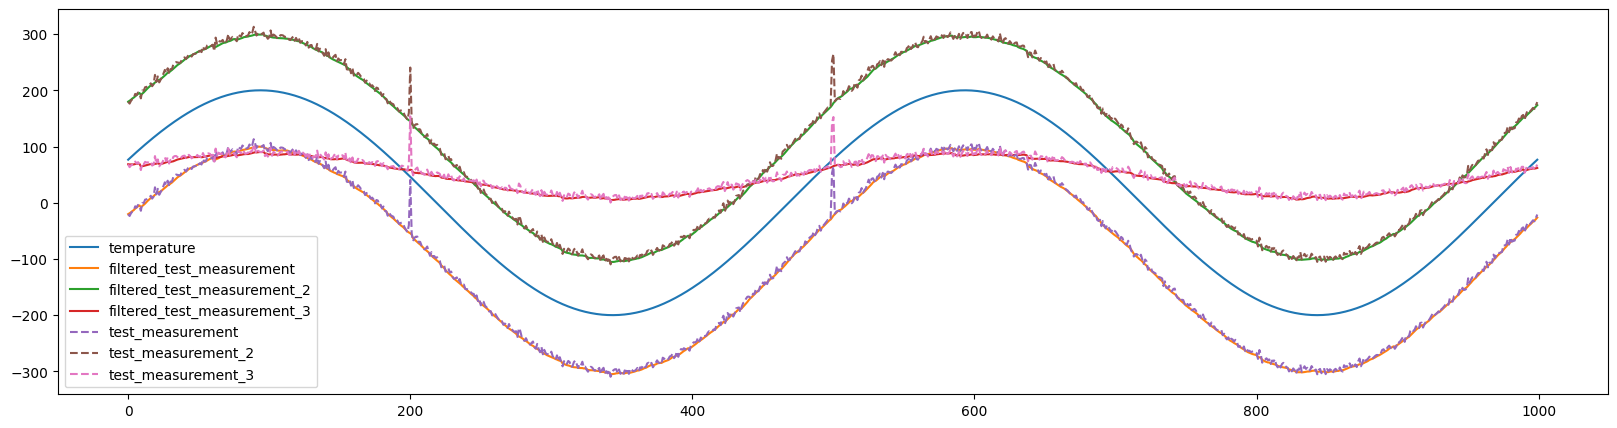

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(y_lf, label='temperature')
for fi in filtered:
    plt.plot(fi['data'], label=fi['name'])

for fi in measurements:
    plt.plot(fi['data'], label=fi['name'], linestyle='--')

#plt.plot(input['data'], label='input', linestyle='-.')
plt.legend()

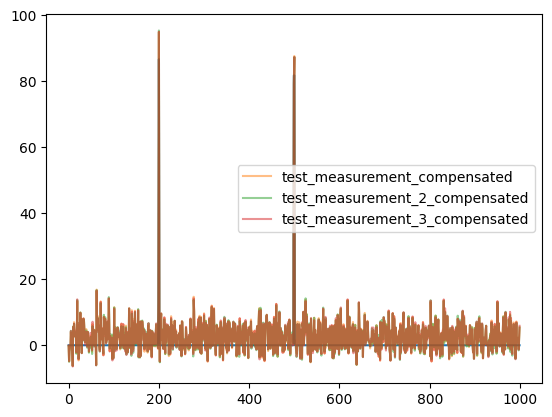

In [ ]:
plt.plot(y_hf)
for i in range(len(filtered)):
    plt.plot(measurements[i]['data'] - filtered[i]['data'], label=measurements[i]['name'] + '_compensated', alpha=0.5)
plt.legend()

In [ ]:
export_states = pfb.export_states()
export_states[0].keys()

dict_keys(['num_particles', 'r_measurement_noise', 'q_process_noise', 'scale', 'loc', 'event_distribution', 'alpha', 'particles', 'weights', 'u_input', 'name', 'timestamp'])

# Create new ParticleFilterBank from the exported states and filter new incoming data

In [ ]:
# Create new pfb from exported states
pfb2 = ParticleFilterBank.from_states(export_states)

In [ ]:
if np.array([]):
    print('empty')

C:\Users\Max\AppData\Local\Temp\ipykernel_18512\566254368.py:1: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if np.array([]):


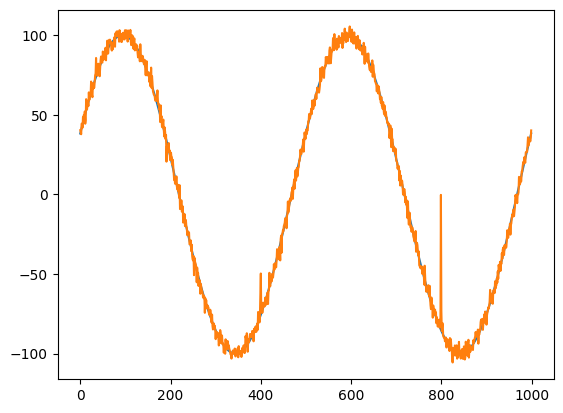

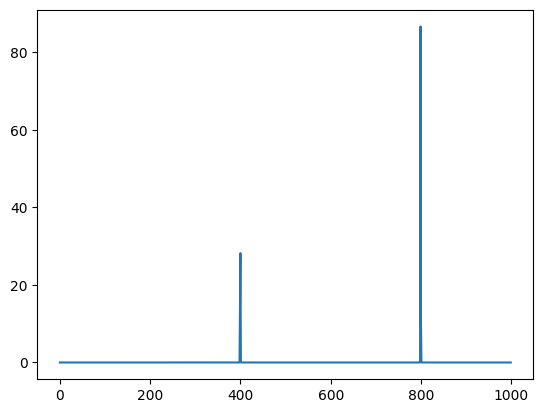

In [ ]:
# New signal arriving to be filtered by the pfb

lf_amplitude2=100
hf_amplitude2=50
no_samples2=1000
lf_frequency2=2
hf_duration2=10
hf_occurence2=24
noise_amplitude2 = 3

t2 = np.linspace(0, 1, no_samples2)   # Timevector

y_lf2 = lf_amplitude2*np.sin(
    2*np.pi*t2*lf_frequency2 + np.pi/8
)

_ , y_hf_2 = gausspulse(t - 0.4, fc=2000, retenv=True)
y_hf_2 = y_hf_2 * hf_amplitude2

_ , y_hf_3 = gausspulse(t - 0.8, fc=2000, retenv=True)
y_hf_3 = y_hf_3 * hf_amplitude

y_hf_1 = y_hf_2 + y_hf_3

# Add noise to y_lf data
y_noise2 = np.random.normal(0, noise_amplitude2, no_samples2)

plt.plot(y_lf2)
plt.plot(y_hf_1+y_lf2+y_noise2)
plt.show()
plt.plot(y_hf_1)
plt.show()

In [ ]:
input2 = {
    'data': y_lf2,
    'name': 'test_lf',
    'unit_str': '°C',
    'fs':1
}


measurements2 = [
    {
    'data':y_lf2 + y_noise2 + y_hf_1-110,
    'name': 'test_measurement',
    'unit_str' : 'microstrain',
    'fs':1
    },
    {
        'data': y_lf2+ 110 + y_noise2 + y_hf_1,
        'name': 'test_measurement_2',
        'unit_str' : 'microstrain',
        'fs':1      
    },
    {
        'data': y_lf2/5 + 50 + y_noise2 + y_hf_1,
        'name': 'test_measurement_3',
        'unit_str' : 'microstrain',
        'fs':1      
    },

]

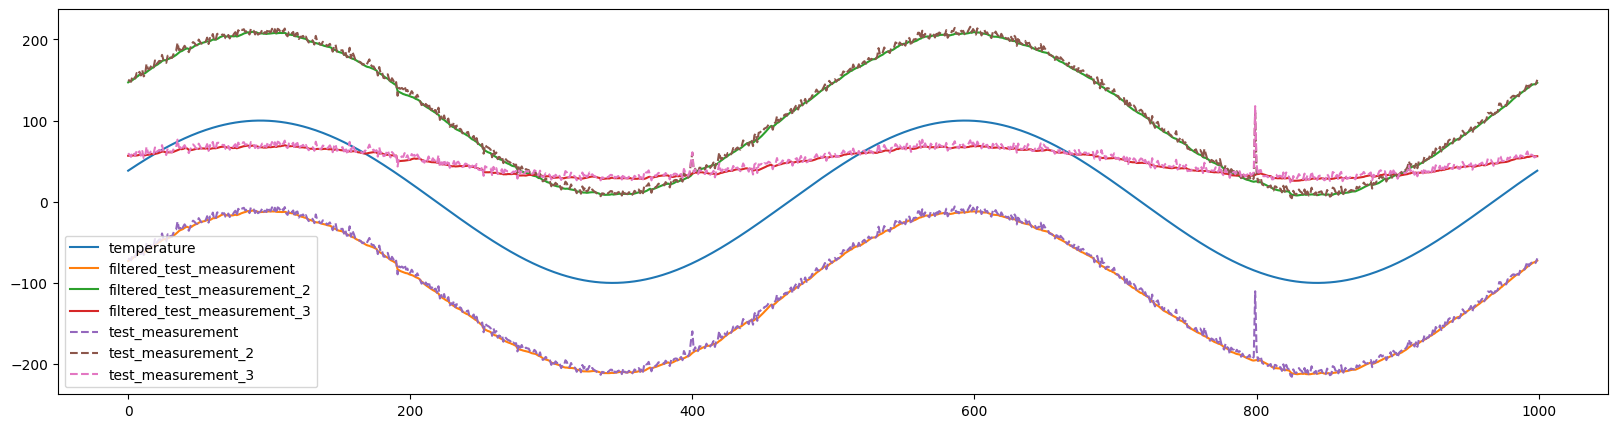

In [ ]:
filtered2 = pfb2.filter(measurements2, input2)
plt.figure(figsize=(20,5))
plt.plot(y_lf2, label='temperature')

for fi in filtered2:
    plt.plot(fi['data'], label=fi['name'])

for fi in measurements2:
    plt.plot(fi['data'], label=fi['name'], linestyle='--')

#plt.plot(input['data'], label='input', linestyle='-.')
plt.legend()

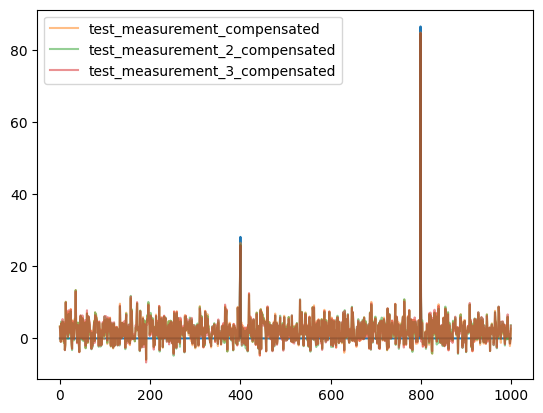

In [ ]:
plt.plot(y_hf_1)
for i in range(len(filtered2)):
    plt.plot(measurements2[i]['data'] - filtered2[i]['data'], label=measurements2[i]['name'] + '_compensated', alpha=0.5)
plt.legend()